# Figure 3: Host DNA percentage

## A: Human host DNA percentage

Importing libraries

In [1]:
import multiprocessing
import pandas as pd
import subprocess
import pysam
import os
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
from plotnine import *

### Summary of BAM files generate by [Anonymap](https://github.com/maxibor/anonymap)

|     Lab    |    Contact    | Origin of samples | Number of samples | Reference human genome used | Westernized ?|
|:----------:|:-------------:|:-----------------:|:-----------------:|:---------------------------:|:-------------|
| Kostic Lab | Marsha Wibowo |         ?         |         49        |            GRCh38           |      yes     |
|  Lewis Lab |  Tanvi Honap  |    Burkina Faso   |         69        |             hg19            |       no     | 
|PRJEB35961 BGISEQ |     -     |    China          |         39        |             GRCh38          |     yes    |

Setting up the list of bam files

In [2]:
human_non_western_bam_dir = "../../data/lewis_lab"
human_non_western_bams = [i for i in os.listdir(human_non_western_bam_dir) if i.endswith(".bam")]
human_western_bam_dir = "../../data/kostic_lab" 
human_western_bams = [i for i in os.listdir(human_western_bam_dir) if i.endswith(".bam")]

In [3]:
pd.Series(human_western_bams).to_frame(name='Sample').to_csv('marsha_samples.csv')

Defining filtering values:

In [4]:
min_id = 0.95
min_len = 20

Defining functions to parse alignment files

In [5]:
def bam_index(bam, bamdir):
    #print(bam)
    cmd = f"samtools index {bamdir}/{bam}"
    try:
        #print(cmd)
        subprocess.check_output(cmd, shell=True)
    except subprocess.CalledProcessError:
        #print(f"Error indexing {bam}")
        pass

In [6]:
def perChromosome(chr, bam, min_id, min_len):
    mapped = 0
    bamfile = pysam.AlignmentFile(bam, "rb")
    reads = bamfile.fetch(chr, multiple_iterators=True)
    for read in reads:
        try:
            cigar = read.get_cigar_stats()[0]
            cigar_d = {'M':cigar[0], 'I': cigar[1], 'D': cigar[2], 'NM': cigar[-1]}
            aln_cols = cigar_d['M']+cigar_d['I']+cigar_d['D']
            nm = cigar_d['NM']
            if cigar_d['M'] == 0:
                continue
            else:
                identity = (aln_cols-nm)/(aln_cols)
                if identity >= min_id and aln_cols >= min_len :
                    mapped +=1
        except:
            continue
    return(mapped)

def getNumberMappedReadsMultiprocess(bam, processes, min_id, min_len):
    try:
        bamfile = pysam.AlignmentFile(bam, "rb")
    except ValueError as e:
        print(e)
    chrs = bamfile.references

    perChromosomePartial = partial(
        perChromosome, bam=bam, min_id = min_id, min_len = min_len)
    p = multiprocessing.Pool(processes)
    result = p.imap_unordered(perChromosomePartial, chrs)
    p.close()
    p.join()
    mapped = sum(result)
    total = bamfile.mapped + bamfile.unmapped
    return({bam.split("/")[-1].split(".")[0]:[mapped, total]})   

#### Handling westernized bam files 

In [7]:
index_western = partial(bam_index, bamdir = human_western_bam_dir)
with multiprocessing.Pool(10) as p:
    p.map(index_western, human_western_bams)

In [8]:
western_res = {}
for i in tqdm(human_western_bams):
    western_res.update(getNumberMappedReadsMultiprocess(bam = f"{human_western_bam_dir}/{i}", processes=10, min_id = min_id, min_len=min_len))

100%|██████████| 49/49 [00:32<00:00,  1.87it/s]


In [9]:
western_human = pd.DataFrame(western_res).T
western_human.columns = 'human_count','all_count'
western_human["percentage_endo"] = western_human['human_count']/western_human['all_count']*100

In [10]:
western_human.head()

,human_count,all_count,percentage_endo
E5,175600,11487470,1.528622
F4,183259,9696234,1.890002
E2,214203,8327324,2.572291
E1,227278,10907632,2.083660
B10,375059,11695702,3.206811


In [11]:
western_human['percentage_endo'].describe()

count    49.000000
mean      1.808109
std       0.806107
min       0.409995
25%       1.258292
50%       1.667870
75%       2.228570
max       3.731088
Name: percentage_endo, dtype: float64

In [12]:
western_human['organism'] = western_human.shape[0]*['Westernized human / Urban']

In [13]:
western_human.to_csv("results/western_human.csv")

#### Handling non westernized bam files 

Because these files were anonymized for the mapping position as well, we can not index them and have to parse them manually from sam files

In [16]:
def bam2sam(bamfile, bamdir):
    print(bamfile)
    basename = bamfile.split(".")[0]
    cmd = f"samtools view {bamdir}/{bamfile} > {bamdir}/{basename}.sam"
    print(cmd)
    subprocess.check_output(cmd, shell = True)

In [17]:
non_western_bam2sam = partial(bam2sam, bamdir = human_non_western_bam_dir)
with multiprocessing.Pool(10) as p:
    p.map(non_western_bam2sam, human_non_western_bams)

bftm0902ecol40.anonym.bam
bftm080321.anonym.bam
bftm2601ext24.anonym.bam
bftm080215.anonym.bam
bftm280135.anonym.bam
bftm270223.anonym.bam
samtools view ../../data/lewis_lab/bftm080321.anonym.bam > ../../data/lewis_lab/bftm080321.sam
bftm190220.anonym.bam
bftm2103ext32.anonym.bam
samtools view ../../data/lewis_lab/bftm2601ext24.anonym.bam > ../../data/lewis_lab/bftm2601ext24.sam
bftm030236.anonym.bam
bftm2002ext29.anonym.bam
samtools view ../../data/lewis_lab/bftm0902ecol40.anonym.bam > ../../data/lewis_lab/bftm0902ecol40.sam
samtools view ../../data/lewis_lab/bftm270223.anonym.bam > ../../data/lewis_lab/bftm270223.sam
samtools view ../../data/lewis_lab/bftm080215.anonym.bam > ../../data/lewis_lab/bftm080215.sam
samtools view ../../data/lewis_lab/bftm2103ext32.anonym.bam > ../../data/lewis_lab/bftm2103ext32.sam
samtools view ../../data/lewis_lab/bftm280135.anonym.bam > ../../data/lewis_lab/bftm280135.sam
samtools view ../../data/lewis_lab/bftm2002ext29.anonym.bam > ../../data/lewis_lab

In [18]:
regex = re.compile("(\d*)[MID]")
def samline(sam, regex=regex, min_id = min_id, min_len=min_len):
    print(sam)
    cnt = 0
    all_cnt = 0
    with open(sam, 'r') as f:
        for l in f:
            lsplit = l.split()
            cigar = lsplit[5]
            all_cnt +=1
            if len(cigar) > 1:
                tags = lsplit[16:18]
                for i in tags:
                    if i.split(':')[0] == 'NM':
                        nm = int(i.split(':')[-1])
                        break
                al_len = sum([int(i) for i in re.findall(regex, cigar)])
                ident = (al_len - nm)/al_len
                if ident >= min_id and al_len>=min_len:
                    cnt+=1
            else:
                continue
    return({sam:[cnt,all_cnt]})

In [19]:
human_non_western_sams = [i for i in os.listdir(human_non_western_bam_dir) if i.endswith(".sam")]

In [20]:
with multiprocessing.Pool(10) as p:
    res = list(tqdm(p.imap_unordered(samline, [f"{human_non_western_bam_dir}/{s}" for s in human_non_western_sams]), total=len(human_non_western_sams)))

  0%|          | 0/69 [00:00<?, ?it/s]

../../data/lewis_lab/bftm2301ext33.sam
../../data/lewis_lab/bftm0401ecol39.sam
../../data/lewis_lab/bftm030236.sam
../../data/lewis_lab/bftm1502ecol15.sam
../../data/lewis_lab/bftm100113.sam
../../data/lewis_lab/bftm230440.sam
../../data/lewis_lab/bftm130122.sam
../../data/lewis_lab/bftm280135.sam
../../data/lewis_lab/bftm070332.sam
../../data/lewis_lab/bftm2401ext31.sam


  1%|▏         | 1/69 [00:52<59:13, 52.26s/it]

../../data/lewis_lab/bftm140428.sam


  3%|▎         | 2/69 [01:13<47:52, 42.87s/it]

../../data/lewis_lab/bftm2103ext32.sam


  4%|▍         | 3/69 [01:15<33:54, 30.82s/it]

../../data/lewis_lab/bftm140127.sam


  6%|▌         | 4/69 [01:19<24:27, 22.57s/it]

../../data/lewis_lab/bftm040212.sam


  7%|▋         | 5/69 [01:41<24:03, 22.56s/it]

../../data/lewis_lab/bftm220210.sam


  9%|▊         | 6/69 [01:56<21:07, 20.12s/it]

../../data/lewis_lab/bftm110237.sam


 10%|█         | 7/69 [02:02<16:34, 16.04s/it]

../../data/lewis_lab/bftm1003ext22.sam


 12%|█▏        | 8/69 [02:10<13:55, 13.69s/it]

../../data/lewis_lab/bftm190220.sam


 13%|█▎        | 9/69 [02:31<15:40, 15.68s/it]

../../data/lewis_lab/bftm180134.sam


 14%|█▍        | 10/69 [03:22<25:49, 26.26s/it]

../../data/lewis_lab/bftm140341.sam


 16%|█▌        | 11/69 [03:35<21:40, 22.42s/it]

../../data/lewis_lab/bftm0202ext20.sam


 17%|█▋        | 12/69 [03:36<15:13, 16.03s/it]

../../data/lewis_lab/bftm270223.sam


 19%|█▉        | 13/69 [03:50<14:24, 15.44s/it]

../../data/lewis_lab/bftm0803ext30.sam


 20%|██        | 14/69 [04:08<14:42, 16.05s/it]

../../data/lewis_lab/bftm1002ecol4.sam


 22%|██▏       | 15/69 [04:27<15:14, 16.94s/it]

../../data/lewis_lab/bftm30016.sam


 23%|██▎       | 16/69 [04:45<15:19, 17.34s/it]

../../data/lewis_lab/bftm0601ext18.sam


 25%|██▍       | 17/69 [05:02<14:57, 17.25s/it]

../../data/lewis_lab/bftm2204ext27.sam


 26%|██▌       | 18/69 [05:42<20:27, 24.07s/it]

../../data/lewis_lab/bftm2801ext35.sam


 28%|██▊       | 19/69 [05:52<16:31, 19.83s/it]

../../data/lewis_lab/bftm1104ecol11.sam


 29%|██▉       | 20/69 [06:03<14:03, 17.20s/it]

../../data/lewis_lab/bftm060125.sam


 30%|███       | 21/69 [06:03<09:42, 12.13s/it]

../../data/lewis_lab/bftm2101ext26.sam
../../data/lewis_lab/bftm1303ext17.sam


 33%|███▎      | 23/69 [06:26<09:05, 11.85s/it]

../../data/lewis_lab/bftm2601ext24.sam


 35%|███▍      | 24/69 [06:35<08:23, 11.19s/it]

../../data/lewis_lab/bftm050238.sam


 36%|███▌      | 25/69 [06:47<08:13, 11.21s/it]

../../data/lewis_lab/bftm0701ecol12.sam


 38%|███▊      | 26/69 [07:28<14:28, 20.20s/it]

../../data/lewis_lab/bftm290124.sam


 39%|███▉      | 27/69 [07:28<10:00, 14.29s/it]

../../data/lewis_lab/bftm09037.sam


 41%|████      | 28/69 [07:56<12:32, 18.35s/it]

../../data/lewis_lab/bftm030111.sam


 42%|████▏     | 29/69 [08:19<13:03, 19.59s/it]

../../data/lewis_lab/bftm3003ext25.sam


 43%|████▎     | 30/69 [08:20<09:06, 14.02s/it]

../../data/lewis_lab/bftm1601ecol9.sam


 45%|████▍     | 31/69 [08:37<09:25, 14.88s/it]

../../data/lewis_lab/bftm0604ecol14.sam


 46%|████▋     | 32/69 [08:51<09:03, 14.68s/it]

../../data/lewis_lab/bftm1704ext28.sam
../../data/lewis_lab/bftm150339.sam


 49%|████▉     | 34/69 [09:01<06:53, 11.81s/it]

../../data/lewis_lab/bftm110126.sam


 51%|█████     | 35/69 [09:32<09:58, 17.59s/it]

../../data/lewis_lab/bftm2301ecol5.sam


 52%|█████▏    | 36/69 [09:46<09:03, 16.46s/it]

../../data/lewis_lab/bftm2704ext23.sam


 54%|█████▎    | 37/69 [09:46<06:12, 11.63s/it]

../../data/lewis_lab/bftm1104ext21.sam


 55%|█████▌    | 38/69 [10:52<14:23, 27.86s/it]

../../data/lewis_lab/bftm1603ecol2.sam


 57%|█████▋    | 39/69 [10:56<10:17, 20.58s/it]

../../data/lewis_lab/bftm26043.sam


 58%|█████▊    | 40/69 [11:03<07:58, 16.51s/it]

../../data/lewis_lab/bftm1701ecol6.sam


 59%|█████▉    | 41/69 [11:03<05:30, 11.79s/it]

../../data/lewis_lab/bftm3004ext36.sam


 61%|██████    | 42/69 [11:24<06:26, 14.31s/it]

../../data/lewis_lab/bftm220116.sam


 62%|██████▏   | 43/69 [11:45<07:06, 16.40s/it]

../../data/lewis_lab/bftm0101ecol.sam


 64%|██████▍   | 44/69 [12:03<07:03, 16.93s/it]

../../data/lewis_lab/bftm2504ecol13.sam


 65%|██████▌   | 45/69 [12:14<06:03, 15.13s/it]

../../data/lewis_lab/bftm150117.sam


 67%|██████▋   | 46/69 [12:15<04:07, 10.74s/it]

../../data/lewis_lab/bftm080321.sam


 68%|██████▊   | 47/69 [12:41<05:37, 15.34s/it]

../../data/lewis_lab/bftm2304ext34.sam


 70%|██████▉   | 48/69 [13:03<06:09, 17.61s/it]

../../data/lewis_lab/bftm1402ext19.sam


 71%|███████   | 49/69 [13:16<05:21, 16.06s/it]

../../data/lewis_lab/bftm120433.sam


 72%|███████▏  | 50/69 [13:29<04:49, 15.24s/it]

../../data/lewis_lab/bftm22034.sam


 74%|███████▍  | 51/69 [13:48<04:51, 16.19s/it]

../../data/lewis_lab/bftm17021.sam


 75%|███████▌  | 52/69 [14:16<05:36, 19.82s/it]

../../data/lewis_lab/bftm080215.sam


 77%|███████▋  | 53/69 [14:43<05:51, 21.96s/it]

../../data/lewis_lab/bftm200129.sam


 78%|███████▊  | 54/69 [14:51<04:28, 17.91s/it]

../../data/lewis_lab/bftm01028.sam


 80%|███████▉  | 55/69 [15:04<03:46, 16.18s/it]

../../data/lewis_lab/bftm200318.sam


 81%|████████  | 56/69 [15:04<02:30, 11.61s/it]

../../data/lewis_lab/bftm2501ecol7.sam


 83%|████████▎ | 57/69 [15:13<02:08, 10.74s/it]

../../data/lewis_lab/bftm0902ecol40.sam


 84%|████████▍ | 58/69 [15:18<01:40,  9.10s/it]

../../data/lewis_lab/bftm010319.sam


 86%|████████▌ | 59/69 [15:32<01:45, 10.58s/it]

../../data/lewis_lab/bftm2002ext29.sam


100%|██████████| 69/69 [17:43<00:00,  6.49s/it]


In [21]:
result_non_western = {}
for d in res:
    result_non_western.update(d)

In [22]:
non_western_human = pd.DataFrame(result_non_western).T
non_western_human = non_western_human.set_index(pd.Series(non_western_human.index.str.split("/lewis_lab/", expand=True).to_frame().iloc[:,1], name="sample"))
non_western_human.columns = ['human_count','all_count']
non_western_human['percentage_endo'] = non_western_human['human_count']/non_western_human['all_count']*100

In [23]:
non_western_human.head()

,human_count,all_count,percentage_endo
sample,,,
bftm2301ext33.sam,55095,18796990,0.293105
bftm070332.sam,49029,26437410,0.185453
bftm030236.sam,77452,27571762,0.280911
bftm2401ext31.sam,7908,28078268,0.028164
bftm280135.sam,4046109,31803446,12.722235


In [24]:
non_western_human['percentage_endo'].describe()


count    69.000000
mean      0.849359
std       2.334063
min       0.012799
25%       0.039551
50%       0.088550
75%       0.293105
max      12.722235
Name: percentage_endo, dtype: float64

In [25]:
non_western_human['organism'] = non_western_human.shape[0]*['Non westernized human / Rural']

In [26]:
non_western_human.to_csv("results/non_western_human.csv")

## B: Dog host DNA percentage

In [28]:
dog_dir = "../../data/dog_PRJEB20308"

In [29]:
dog_bams= [i for i in os.listdir(dog_dir) if i.endswith(".unfiltered.aligned.bam")]

In [30]:
index_dog = partial(bam_index, bamdir = dog_dir)
with multiprocessing.Pool(10) as p:
    list(tqdm(p.imap(index_dog, dog_bams), total = len(dog_bams)))

100%|██████████| 150/150 [00:47<00:00,  3.07it/s]


In [31]:
dog_mapped = {}
for i in tqdm(dog_bams):
    try:
        dog_mapped.update(getNumberMappedReadsMultiprocess(f"{dog_dir}/{i}", processes=10, min_id=min_id, min_len=min_len))
    except:
        continue

100%|██████████| 150/150 [00:34<00:00,  5.06it/s]


In [32]:
dog_count = pd.DataFrame(dog_mapped).T

In [33]:
dog_count.columns = ['dog_count','all_count']

In [34]:
dog_count['percentage_endo'] = dog_count['dog_count']/dog_count['all_count']*100

In [35]:
dog_count['organism'] = ['Dog']*dog_count.shape[0]

In [36]:
dog_count.to_csv("results/dogs.csv")

# C: Combining results

In [4]:
non_western_human = pd.read_csv("results/non_western_human.csv", index_col=0)
western_human = pd.read_csv("results/western_human.csv", index_col=0)
dog_count = pd.read_csv("results/dogs.csv", index_col=0)

In [14]:
host_dna = (western_human[['percentage_endo','organism']]
       .append(non_western_human[['percentage_endo','organism']])
       .append(dog_count[['percentage_endo','organism']])).rename(columns={'percentage_endo':'percentage_host_DNA'})

In [20]:
tab_s1 = (western_human.rename(columns={'human_count':'host_read_count', 'all_count':'all_read_count'}).
 append(non_western_human.rename(columns={'human_count':'host_read_count', 'all_count':'all_read_count'})).
 append(dog_count.rename(columns={'dog_count':'host_read_count', 'all_count':'all_read_count'})))
tab_s1.rename(columns={'percentage_endo':'percentage_host_DNA'}, inplace=True)
tab_s1['percentage_host_DNA'] = tab_s1['percentage_host_DNA'].round(2)
tab_s1.to_csv("tab_S1.csv", index_label = 'sample')

In [21]:
host_dna['organism'] = pd.Categorical(host_dna.organism, categories= ['Non westernized human / Rural', 'Westernized human / Urban', 'Dog'], ordered=True)

Median per category

In [29]:
host_dna.groupby('organism')['percentage_host_DNA'].median().round(2).to_frame()

,percentage_host_DNA
organism,
Non westernized human / Rural,0.09
Westernized human / Urban,1.67
Dog,0.04


Mean per category

In [30]:
host_dna.groupby('organism')['percentage_host_DNA'].mean().round(2).to_frame()

,percentage_host_DNA
organism,
Non westernized human / Rural,0.85
Westernized human / Urban,1.81
Dog,0.11


Standard deviation per category

In [31]:
host_dna.groupby('organism')['percentage_host_DNA'].std().round(2).to_frame()

,percentage_host_DNA
organism,
Non westernized human / Rural,2.33
Westernized human / Urban,0.81
Dog,0.16


In [42]:
host_dna_median = host_dna.groupby('organism')['percentage_host_DNA'].median().round(2).to_frame()

In [43]:
host_dna_median['count']=host_dna.groupby('organism').count()

In [44]:
host_dna_median['percentage_host_label'] = 'med=' + host_dna_median['percentage_host_DNA'].astype(str)
host_dna_median['count'] = 'N=' + host_dna_median['count'].astype(str)

In [45]:
host_dna_median = host_dna_median.reset_index()

In [46]:
host_dna_median

,organism,percentage_host_DNA,count,percentage_host_label
0,Non westernized human / Rural,0.09,N=69,med=0.09
1,Westernized human / Urban,1.67,N=49,med=1.67
2,Dog,0.04,N=150,med=0.04


## Color palette:
- Westernized human / Urban: '#c40000'
- Non westernized human / Rural: '#ff7b00'
- Unknown: '#a2a3a1'
- Soil: '#75a51c'
- Dog: '#2166ac'

In [36]:
host_dna.head()

,percentage_host_DNA,organism
E5,1.528622,Westernized human / Urban
F4,1.890002,Westernized human / Urban
E2,2.572291,Westernized human / Urban
E1,2.083660,Westernized human / Urban
B10,3.206811,Westernized human / Urban


/projects1/users/borry/15_miniconda3/lib/python3.7/site-packages/plotnine/positions/position.py:201: PlotnineWarning: position_dodge requires non-overlapping x intervals
  warn(msg.format(cls.__name__), PlotnineWarning)
/projects1/users/borry/15_miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/projects1/users/borry/15_miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:720: PlotnineWarning: Filename: results/figure3.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/projects1/users/borry/15_miniconda3/lib/python3.7/site-packages/plotnine/positions/position.py:201: PlotnineWarning: position_dodge requires non-overlapping x intervals
  warn(msg.format(cls.__name__), PlotnineWarning)
/projects1/users/borry/15_miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:735: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will

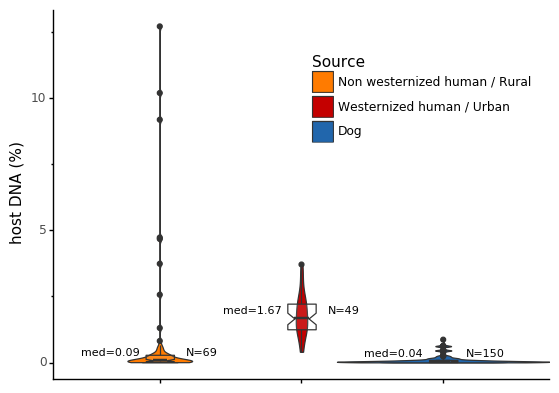

In [55]:
p = ggplot(host_dna, aes(x="organism", y="percentage_host_DNA")) + geom_violin(aes(fill="organism"))
p = p + geom_violin(aes(fill='organism'), width=1.5)
p = p + geom_boxplot(alpha=0.1, width=0.2, notch=True) 
p = p + geom_text(data = host_dna_median, mapping = aes(x='organism',y='percentage_host_DNA',label='percentage_host_label'), size = 8, nudge_x=-0.35, nudge_y=0.28)
p = p + geom_text(data = host_dna_median, mapping = aes(x='organism',y='percentage_host_DNA',label='count'), size = 8, nudge_x=+0.3, nudge_y=0.28)
# p = p + geom_dotplot(aes(fill='organism'),binaxis='y', stackdir='center', binwidth=0.05, alpha=0.2, stackratio = 0.4)
p = p + labs(x = '', y='host DNA (%)') 
# p = p + theme_classic() + theme(legend_position = (0.7,0.7), axis_text_x=element_text(angle=45, hjust=1))
p = p + theme_classic() + theme(legend_position = (0.7,0.7), axis_text_x=element_blank())
p = p + scale_fill_manual(name = "Source", values = {"Dog":"#2166ac","Non westernized human / Rural":"#ff7b00","Westernized human / Urban":"#c40000"})
p.draw()
p.save('results/figure3.png', dpi=300)

## Statistical testing

In [58]:
dog_host = host_dna.loc[host_dna.index[host_dna['organism'] == 'Dog'],'percentage_host_DNA']
w_human_host = host_dna.loc[host_dna.index[host_dna['organism'] == 'Westernized human / Urban'],'percentage_host_DNA']
nw_human_host = host_dna.loc[host_dna.index[host_dna['organism'] == 'Non westernized human / Rural'],'percentage_host_DNA'] 

## Testing for normality with Shapiro test

*The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.*

In [57]:
from scipy.stats import shapiro

For westernized humans

In [56]:
shapiro(w_human_host)

NameError: name 'shapiro' is not defined

The westernized human samples appear to be drawn from a normal distribution

In [50]:
shapiro(nw_human_host)

(0.39096003770828247, 2.0963362407197712e-15)

The non-westernized human samples do not appear to be drawn from a normal distribution

In [51]:
shapiro(dog_host)

(0.6248308420181274, 5.593901123028149e-18)

The dog samples appear to be drawn from a normal distribution

## Comparing sample groups

Because two of the three groups are not drawn from normal distributions, we will use the non-parametric alternatives of the ANOVA and t-test

"The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal."
It is the non-parametric alternative of the ANOVA

In [59]:
stats.kruskal(dog_host, w_human_host, nw_human_host)

KruskalResult(statistic=117.4070038210566, pvalue=3.2017915333474645e-26)

The *p value* is < 0.05, there is a difference between the medians of the three sources

#### Dog vs Non westernized human

"The Mann–Whitney U test can be used to determine whether two independent samples were selected from populations having the same distribution.
The alternative hypothesis H1 is that the distributions are not equal."

In [60]:
stats.mannwhitneyu(dog_host, nw_human_host)

MannwhitneyuResult(statistic=3327.0, pvalue=1.1114072840938185e-05)

The p value is < 0.05: distributions are not equal. (H0 rejected)

#### Dog vs Westernized human

In [61]:
stats.mannwhitneyu(dog_host, w_human_host)

MannwhitneyuResult(statistic=41.0, pvalue=1.5061670087718647e-25)

The p value is < 0.05: distributions are not equal. (H0 rejected)

#### Westernized human vs Non Westernized human

In [62]:
stats.mannwhitneyu(w_human_host, nw_human_host)

MannwhitneyuResult(statistic=370.0, pvalue=2.8204595467795166e-13)

The p value is < 0.05: distributions are not equal. (H0 rejected)

#### Dog vs all Human

In [63]:
human_host= host_dna.loc[host_dna.index[host_dna['organism'].isin(['Westernized human / Urban','Non westernized human / Rural'])] ,'percentage_host_DNA']

In [64]:
human_host.describe()

count    118.000000
mean       1.247484
std        1.912581
min        0.012799
25%        0.070754
50%        0.485618
75%        1.846473
max       12.722235
Name: percentage_host_DNA, dtype: float64

In [65]:
dog_host.describe()

count    150.000000
mean       0.106391
std        0.158886
min        0.005393
25%        0.018799
50%        0.041548
75%        0.100043
max        0.865627
Name: percentage_host_DNA, dtype: float64

In [66]:
stats.mannwhitneyu(dog_host, human_host)

MannwhitneyuResult(statistic=3368.0, pvalue=1.6280714998906906e-18)

The p value is < 0.05: distributions are not equal. (H0 rejected)